# Wavefront Propagation and PSF simulation with Scoob
The scoobPSF package builds a layer on-top of poppy that is specific to the scoob optical bench.
This notebook demonstrates how to simulate monochromatic PSFs and wavefronts with the scoobPSF package. <br>


9.3 mm


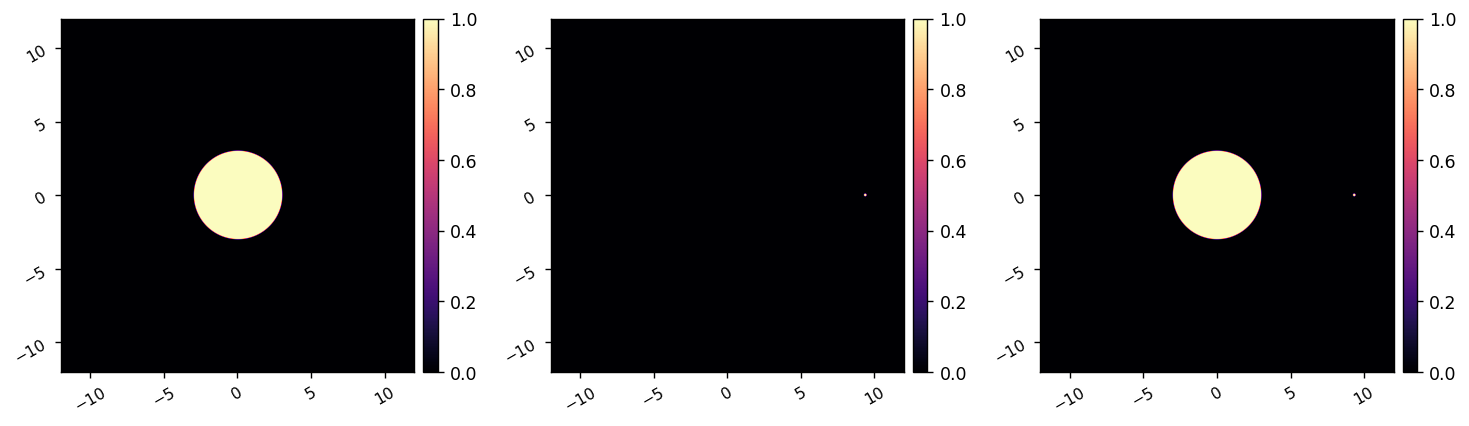

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys

poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

lyot_diam = 8.6*u.mm
lyot_diam = 6.0*u.mm
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0,)
scc_pinhole = poppy.CircularAperture(name='SCC Pinhole', radius=0.03*lyot_diam/2, shift_x=1.55*lyot_diam)

wf = poppy.FresnelWavefront(beam_radius=lyot_diam/2, npix=512, oversample=4)
lyot_ap = lyot_stop.get_transmission(wf)
scc_ap = scc_pinhole.get_transmission(wf)

scc_lyot_stop = poppy.ArrayOpticalElement(transmission=lyot_ap+scc_ap, pixelscale=wf.pixelscale, name='Lyot/SCC Mask')

print(scc_pinhole.shift_x)
imshow3(lyot_ap, scc_ap, scc_lyot_stop.amplitude, pxscl=scc_lyot_stop.pixelscale.to(u.mm/u.pix))

In [26]:
reload(scoob)
model = scoob.SCOOBM(oversample=8, 
                    #  use_synthetic_opds=True,
                     )

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=model.wavelength_c, charge=6, singularity=20*u.um)

model.FPM = vortex
model.LYOT = scc_lyot_stop
# model.LYOT = lyot_stop
# model.d_oap7_CAM += -0.01*u.mm

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


In [22]:
um_per_lamD = model.psf_pixelscale.to(u.um/u.pix)*u.pix/model.psf_pixelscale_lamD
um_per_lamD

<Quantity 20.82909719 um>

In [23]:

um_per_lamD = model.psf_pixelscale.to(u.um/u.pix)*u.pix/model.psf_pixelscale_lamD
mrad_per_lamD = ((model.wavelength_c/model.pupil_diam).decompose()*u.radian).to(u.mrad)

model.source_offset = (4.299/2,0) # in units of lamD

print(model.source_offset[0]*mrad_per_lamD)

fsm_angle = np.array([0.1, 0.2])*u.mrad
print(fsm_angle)

fsm_offset = 2*fsm_angle/mrad_per_lamD
print(fsm_offset)

0.20151164444444447 mrad
[0.1 0.2] mrad
[2.13337547 4.26675095]


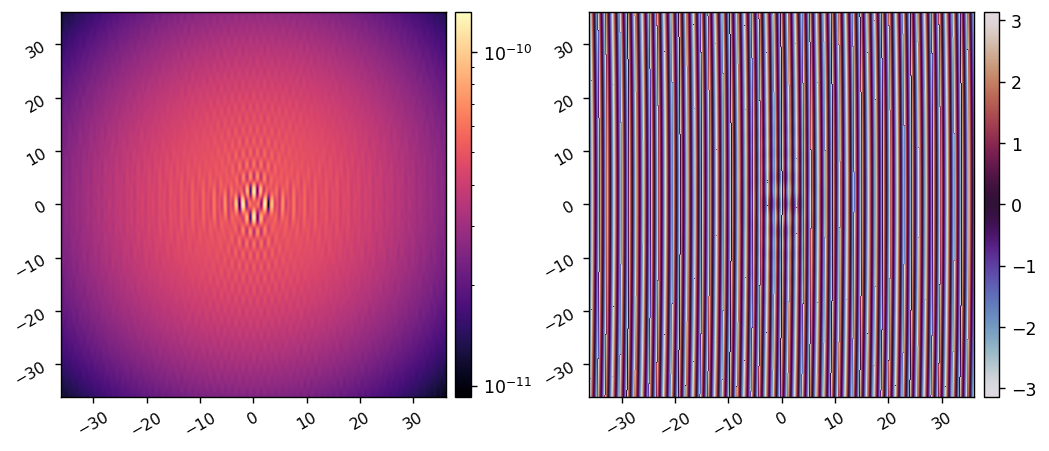

In [27]:
# model.source_offset = (10,0)
imwf = model.calc_wf(plot=True)

Propagating wavelength 632.800 nm.
PSF calculated in 0.178s


['after Pupil Stop/FSM',
 'after Phase Retrieval Place-holder',
 'after OAP1',
 'after IFP1',
 'after OAP2',
 'after DM',
 'after OAP3',
 'after VVC',
 'after Fold Flat 1',
 'after OAP4',
 'after Fold Flat 2',
 'after Lyot Pupil',
 'after Lyot/SCC Mask',
 'after OAP5',
 'after Field stop Place-holder',
 'after OAP6',
 'after OAP7',
 'at Focal Plane']

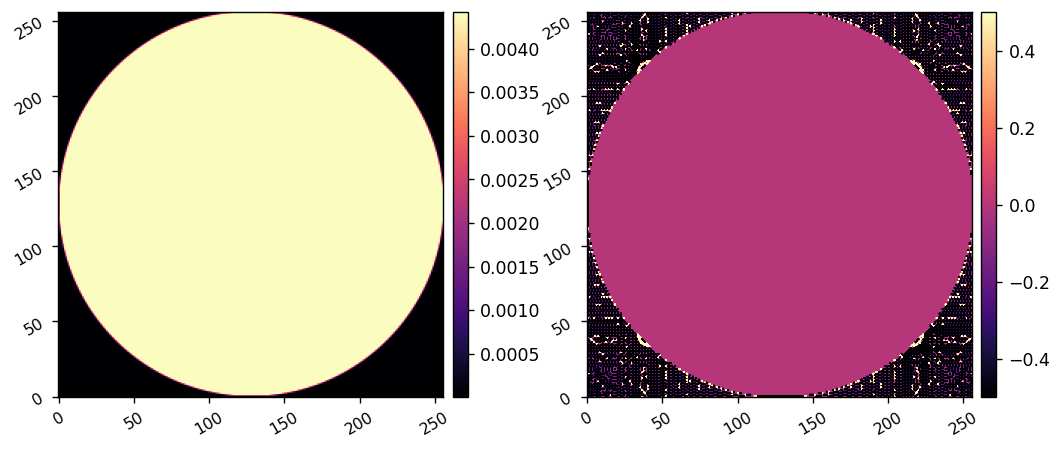

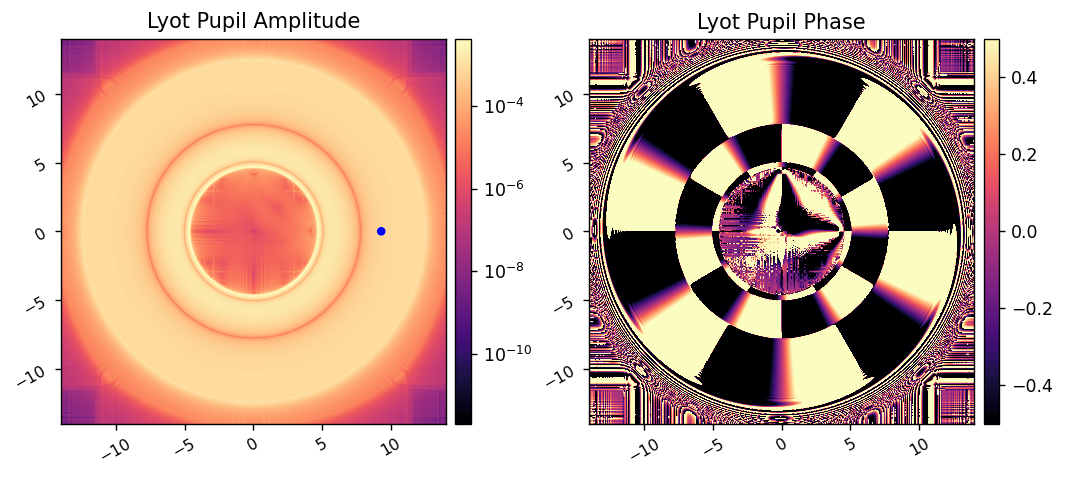

In [30]:
model.use_synthetic_opds = False
wfs = model.calc_wfs()

names = [wf.location for wf in wfs]
display(names)

for i,name in enumerate(names):
    if 'DM' in name: dm_ind = i
    if 'Lyot Pupil' in name: lyot_ind = i

circ = Circle((scc_pinhole.shift_x.to_value(u.mm), 0), 1/4, color='b')
imshow2(wfs[dm_ind].amplitude, wfs[dm_ind].phase, npix=model.npix, vmin2=-0.5, vmax2=0.5)
imshow2(wfs[lyot_ind].amplitude, wfs[lyot_ind].phase, 'Lyot Pupil Amplitude', 'Lyot Pupil Phase',
        # npix=4*model.npix,
        lognorm1=True,
        axlims=np.array([-14,14,-14,14]),
        patches1=[circ],
         vmin2=-0.5, vmax2=0.5, pxscl=wfs[lyot_ind].pixelscale.to(u.mm/u.pix))

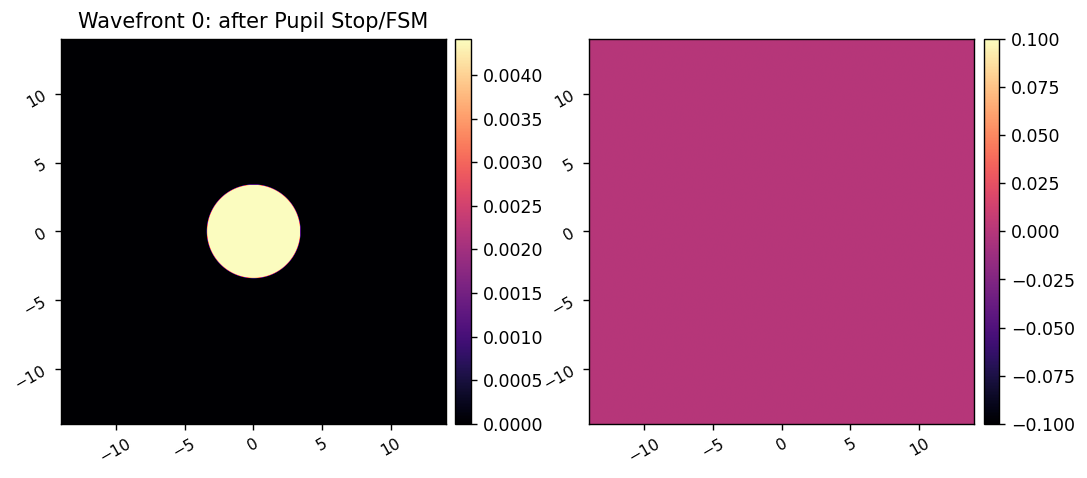

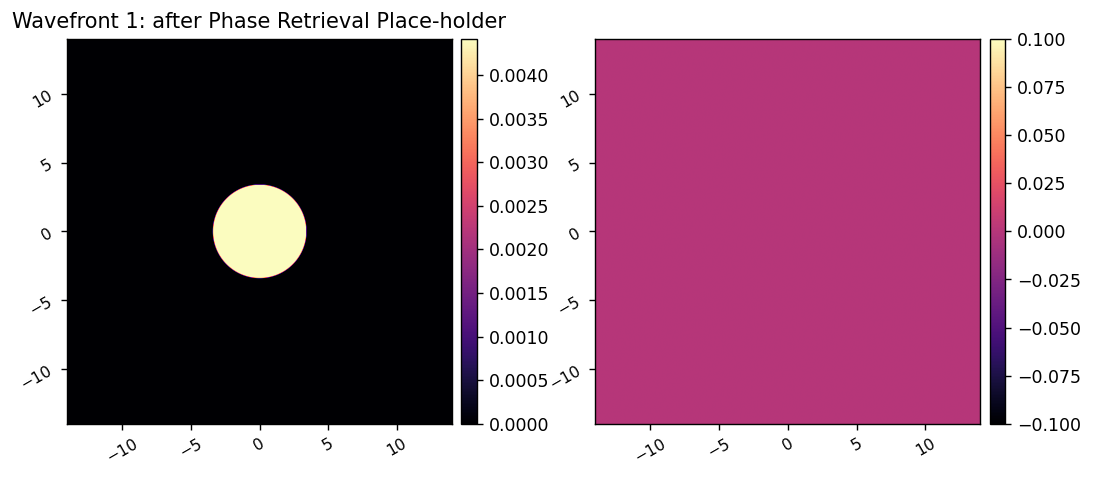

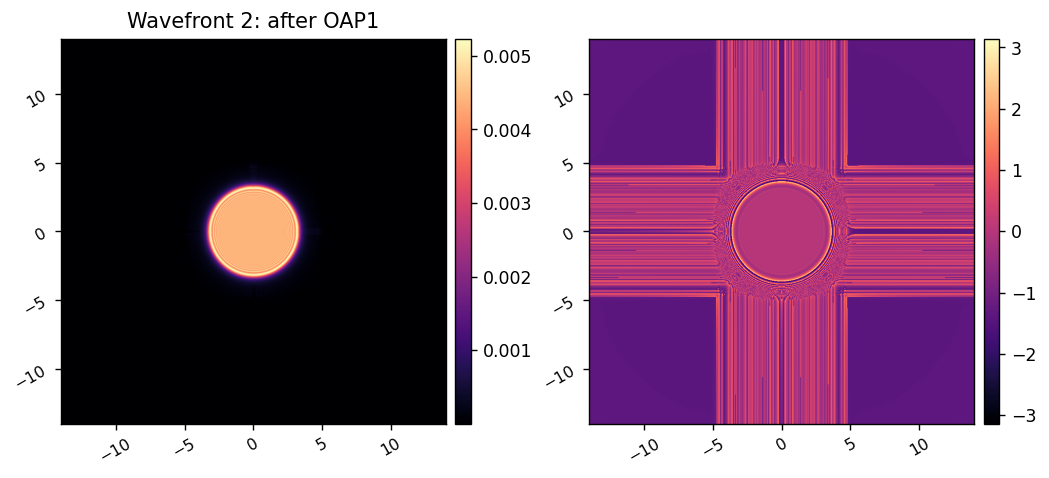

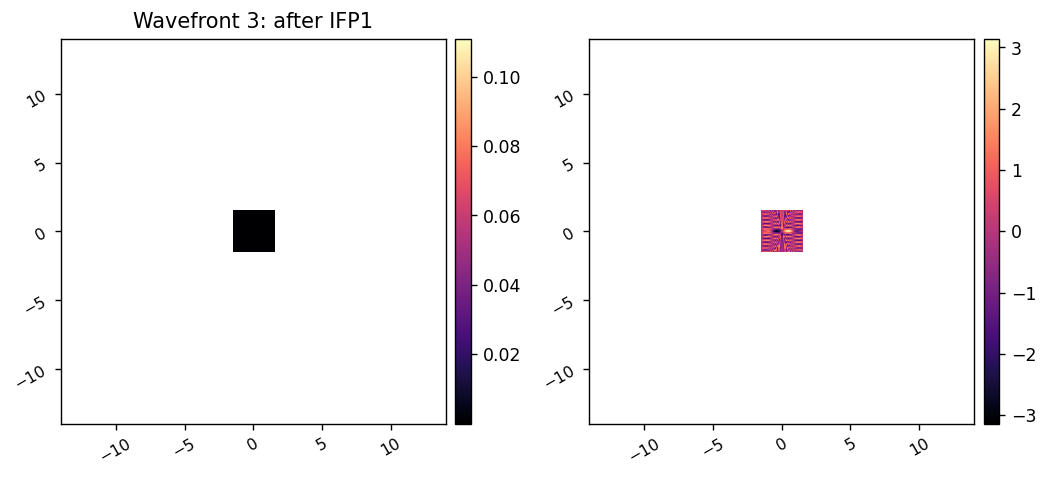

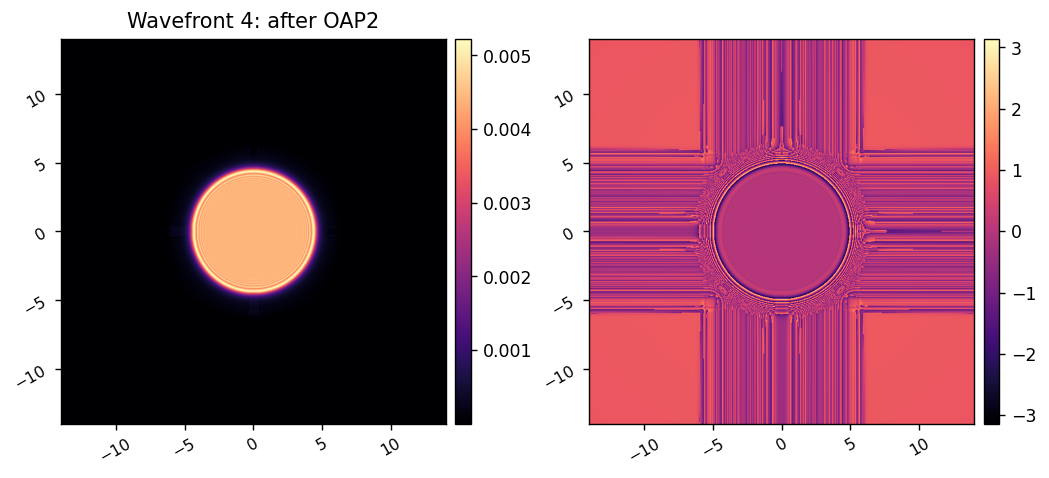

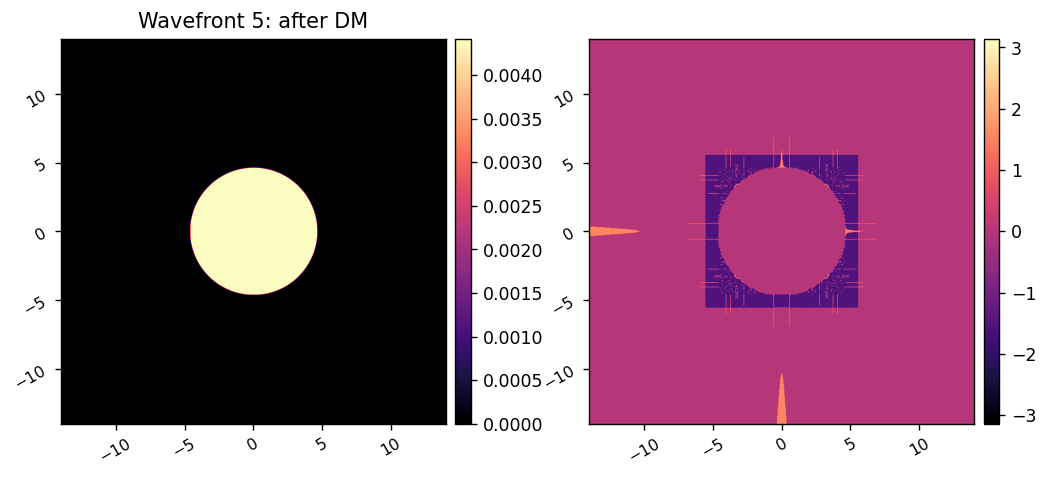

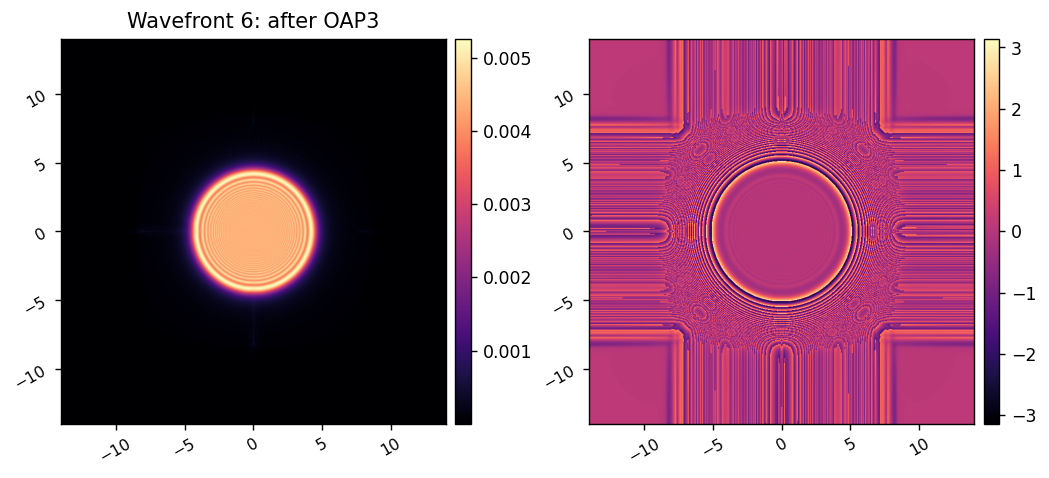

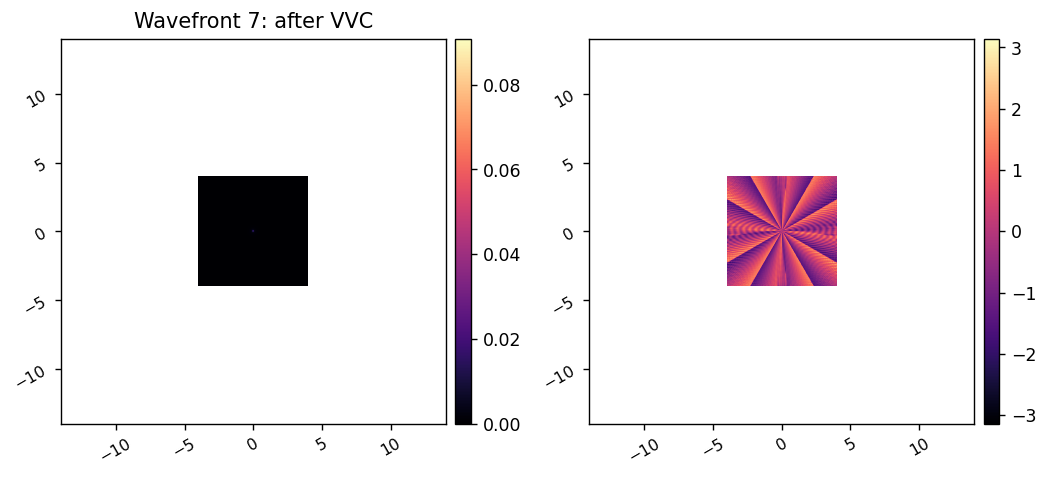

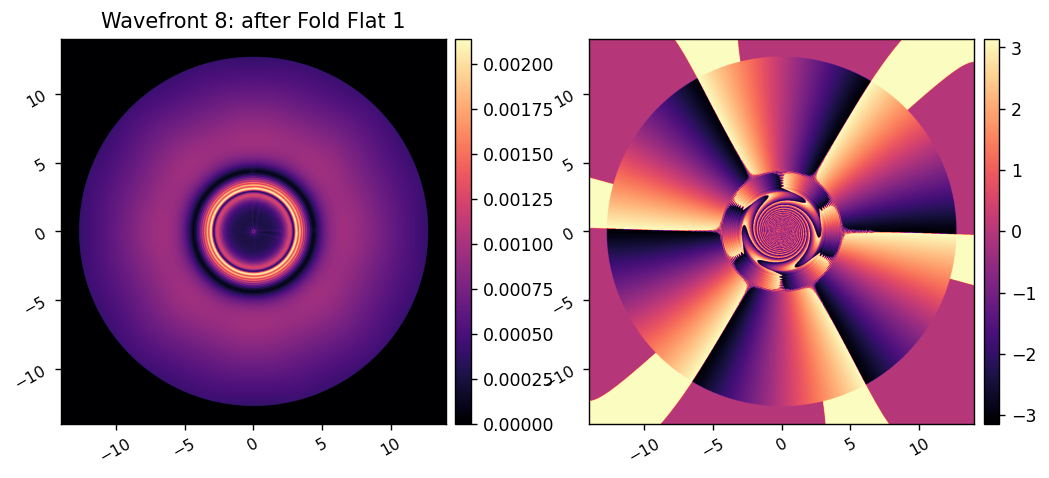

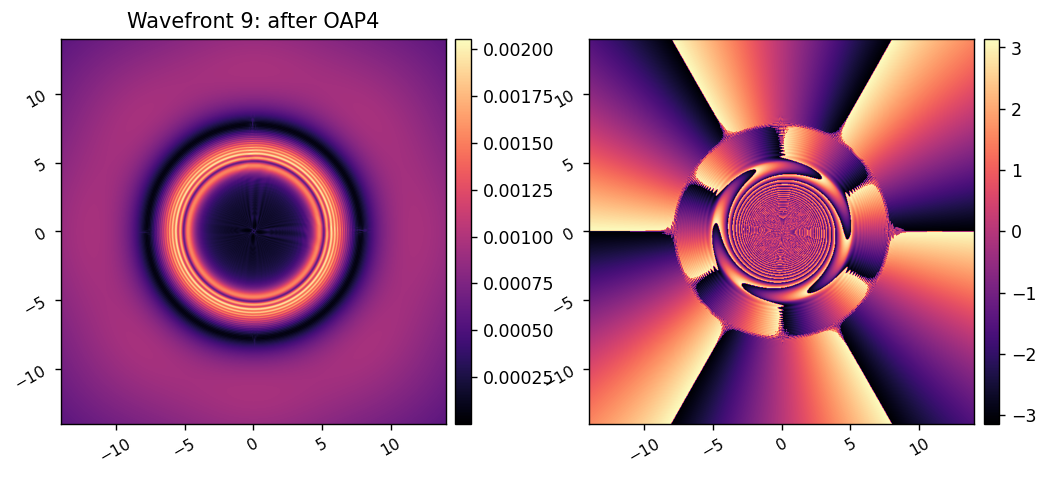

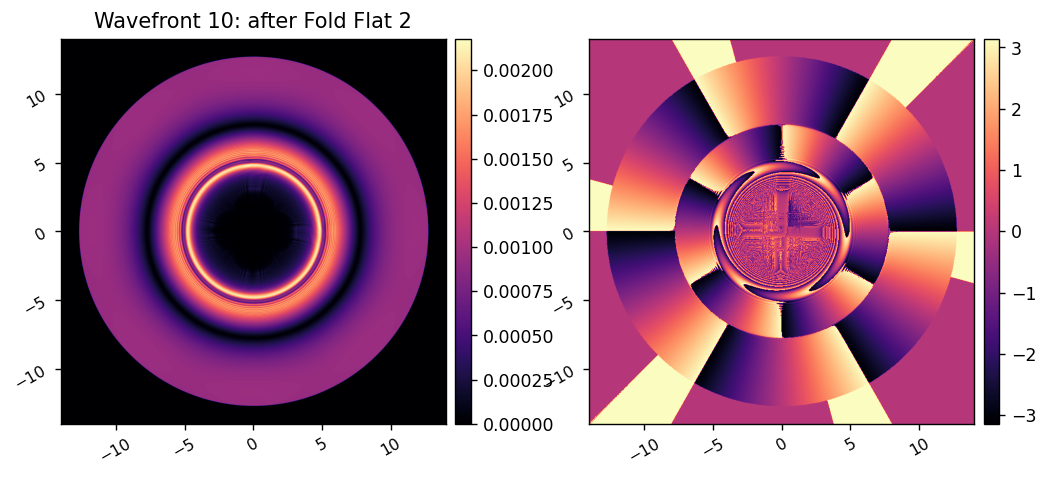

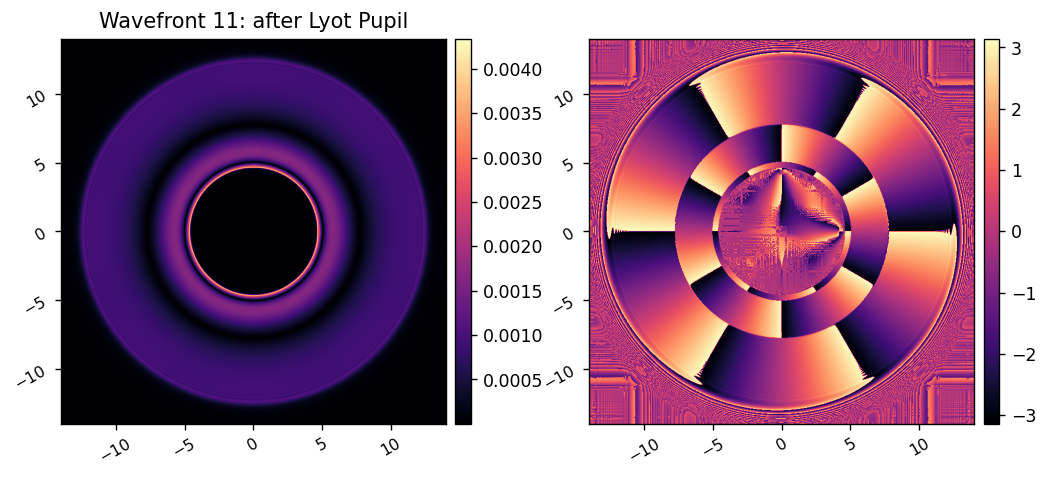

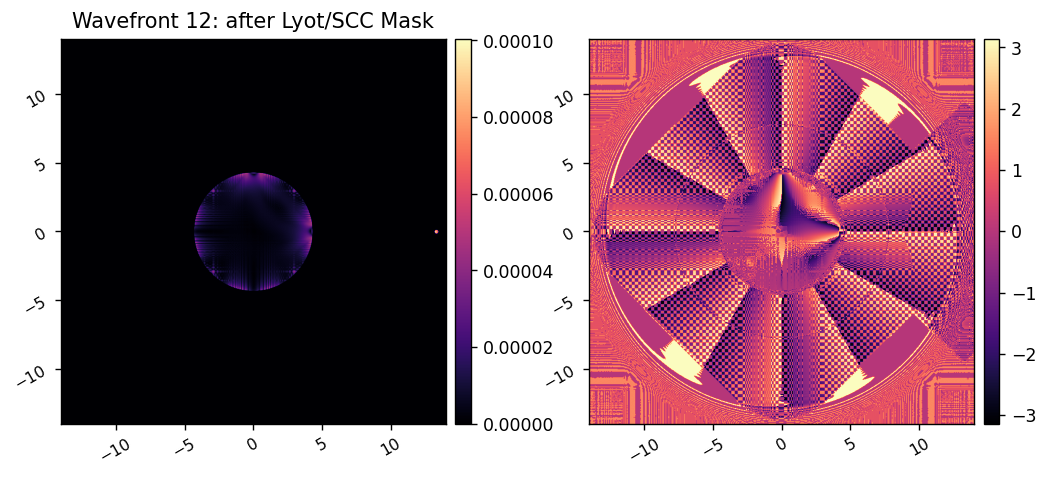

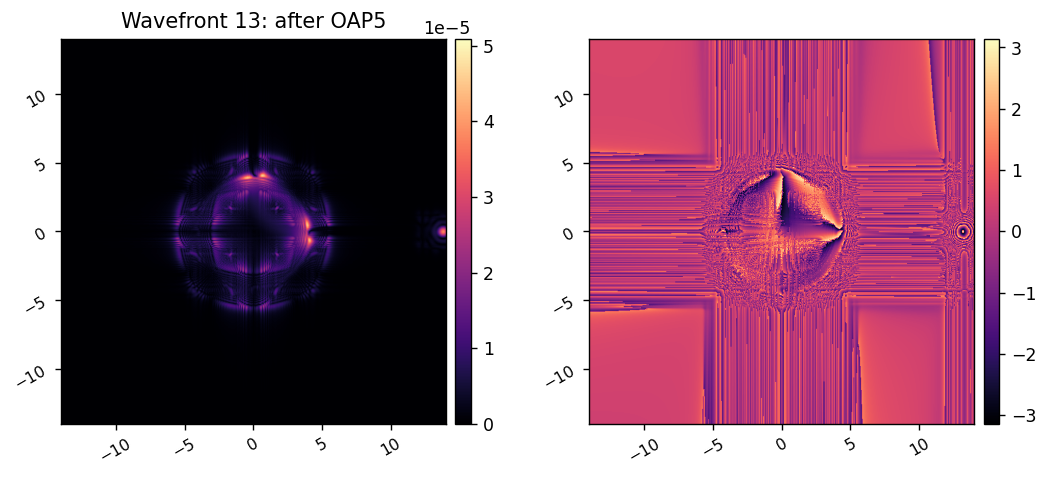

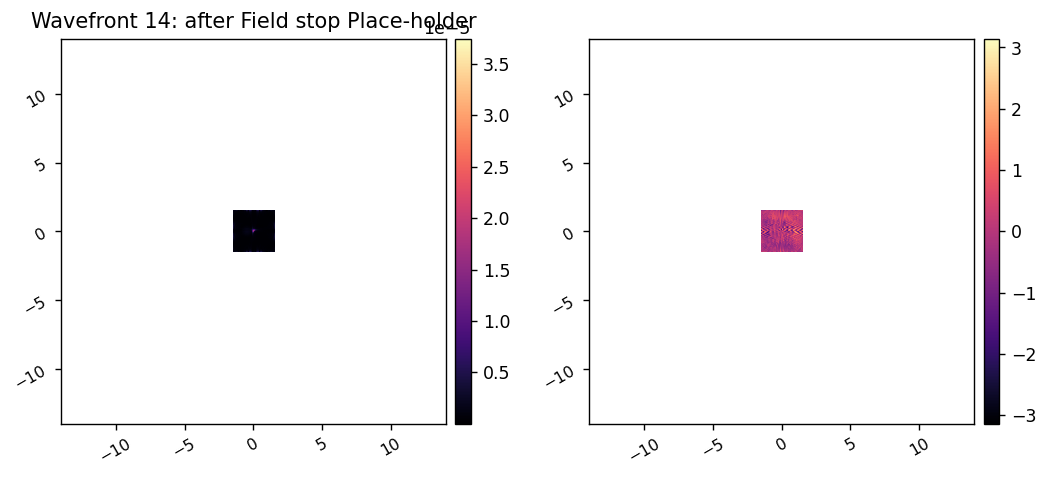

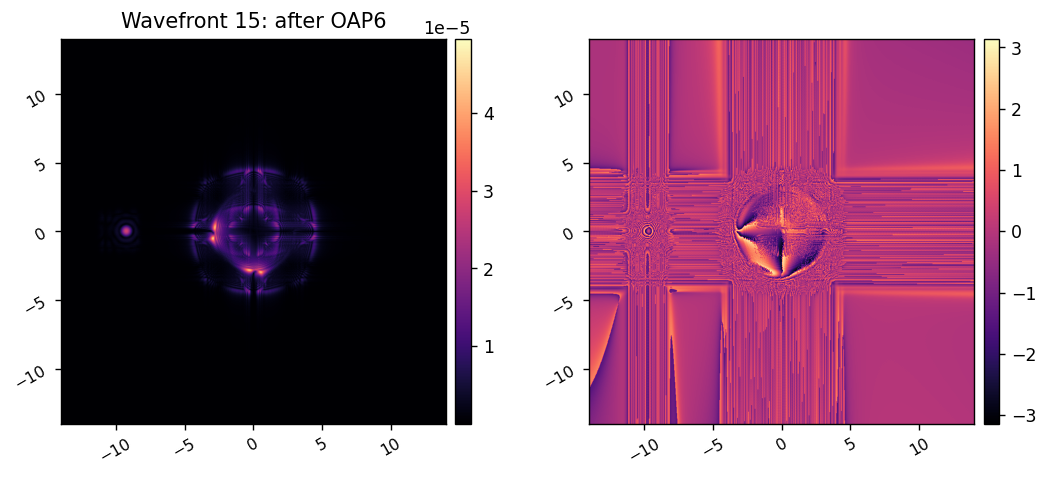

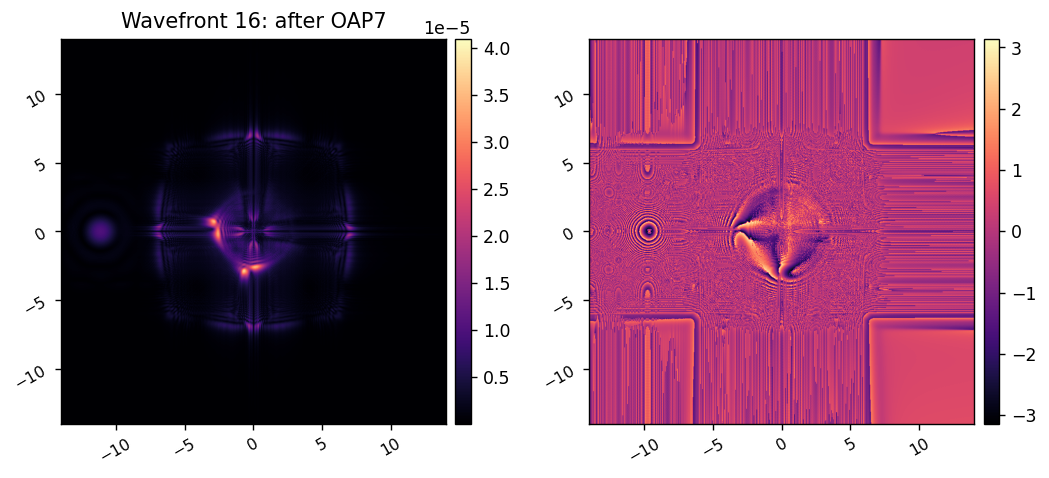

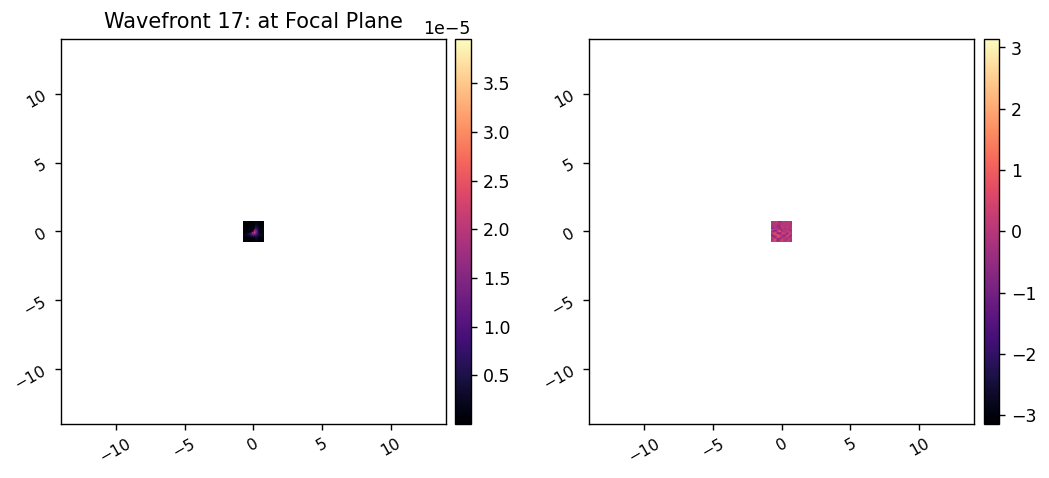

In [9]:
for i in range(len(wfs)):
    if 'focal plane' in wfs[i].location.lower() or 'detector' in wfs[i].location.lower():
        pass
    else:
        npix = model.npix
    imshow2(wfs[i].amplitude, wfs[i].phase, f'Wavefront {i}: ' + wfs[i].location, 
            # npix=3*model.npix,
            axlims=[-14, 14, -14, 14], 
            pxscl=wfs[i].pixelscale.to(u.mm/u.pix))
    

In [60]:
wfs[12].pixelscale.to_value(u.mm/u.pix) * model.npix

9.259360081205521

In [58]:
dir(wfs[-1])

['__abstractmethods__',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_display_after_optic',
 '_display_hint_expected_nplanes',
 '_fft',
 '_image_centered',
 '_inv_fft',
 '_pixelscale_m',
 '_propagate_ptp',
 '_propagate_stw',
 '_propagate_wts',
 '_resample_wavefront_pixelscale',
 '_x',
 '_y',
 'amplitude',
 'angular_coordinates',
 'apply_image_plane_fftmft',
 'apply_lens_power',
 'as_fits',
 'coordinates',
 'copy',
 'current_plane_index',
 'diam',
 'display',
 'divergence',
 'dtype',
 'focal_length',
 'fov',
 'from_wavefront',
 'history',
 'i

In [59]:
wfs[-1].z_w0, wfs[-1].z, wfs[-1].z_w0-wfs[-1].z

(<Quantity 3.68719139 m>, <Quantity 3.68719139 m>, <Quantity 0. m>)